In [1]:
print("HI")

HI


In [11]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
from esm.data import ESMStructuralSplitDataset
import os

dataset = ESMStructuralSplitDataset(
    split_level='family', 
    cv_partition='0', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
    download=True
)

# Extract sequences from the dataset
sequences = [data['seq'] for data in dataset]

100%|███████████████████████████████████████████████████████████████████████████████████| 744059/744059 [00:00<00:00, 3206678.07it/s]


100%|██████████████████████████████████████████████████████████████████████████| 2601334121/2601334121 [01:42<00:00, 25341573.84it/s]


# EDA

In [22]:
dataset[0]

{'seq': 'MATSLNTIDIQGDILVGMHKQKQLFYFFAINDPATFKTHLASDIAPVVASVTQLSNVATQPLVALNIAFSNTGLLALGVTDNLGDSLFANGQAKDATSFKESTSSWVPQFAGTGIHGVIILASDTTDLIDQQVASIESTFGSSISKLSSLSASIRPGNEAGHEMFGFLDGIAQPAINGFNTPLPGQNIVDAGVIITGATNDPITRPSWAVGGSFLAFRQLEQLVPEFNKYLLDNAPAGSGSLQARADLLGARMVGRWKSGAPIDLTPTADDPALGADAQRNNNFTYSHAGFDLGSDQSHCPFSAHIRKTRPRADLGGSLTPPNLSAGANSIMRSGIPYGPEVTSAESASNTTTQERGLAFVAYQAQLSQGFHFLQQTWADNANFPPGKTPATVGLDPIIGQNNGQPRVVNGLLPSNSSASLSIPQFVVSHGGEYFFSPPISAIGGRLSA',
 'ssp': 'XXX---GGGSBHHHHT----SEEEEEEEEE-SHHHHHHHIIIIIGGGB-BHHHHTSTTS--SEEEEEEE-HHHHHHTT-----S-HHHHH-HHHHGGGGT--GGGS-GGGSSS---EEEEEEESSHHHHHHHHHHHHHHHGGGEEEEEEEEEE---GGGTTB-TTS-B-S----EETTTS---TT--EE-GGGTSTTSTT--S---GGGTT-EEEEEEEEEE-HHHHHHHHHHT----SS-HHHHHHHHHHHHHSB-TTS-BTTTSSSS--HHHHH-TTTTT---S--TTS-TTT--SSS-TT-HHHHHS-GGGGSS-SSS---TTGGG--EE--EEES----HHHHHHT---S--EEEEEEEES-TTTTHHHIIIIIIT-TT-STT-SSS--B--TTT--STTS-EEEES--TT-TT-EEEE--SEEEEEEEEEEE--HHHHHTGGG-',
 'dist': array([[      nan,       nan,       nan, ...,       nan,       nan,
 

In [3]:
num_sequences = len(sequences)
num_sequences

12026

In [5]:
seq_lengths = [len(seq) for seq in sequences]
seq_lengths[0:5]

[449, 99, 101, 100, 318]

In [8]:
print(f"Number of sequences: {num_sequences}")
print(f"Average sequence length: {np.mean(seq_lengths):.2f}")
print(f"Median sequence length: {np.median(seq_lengths):.2f}")
print(f"Minimum sequence length: {min(seq_lengths)}")
print(f"Maximum sequence length: {max(seq_lengths)}")

Number of sequences: 12026
Average sequence length: 198.24
Median sequence length: 166.00
Minimum sequence length: 40
Maximum sequence length: 882


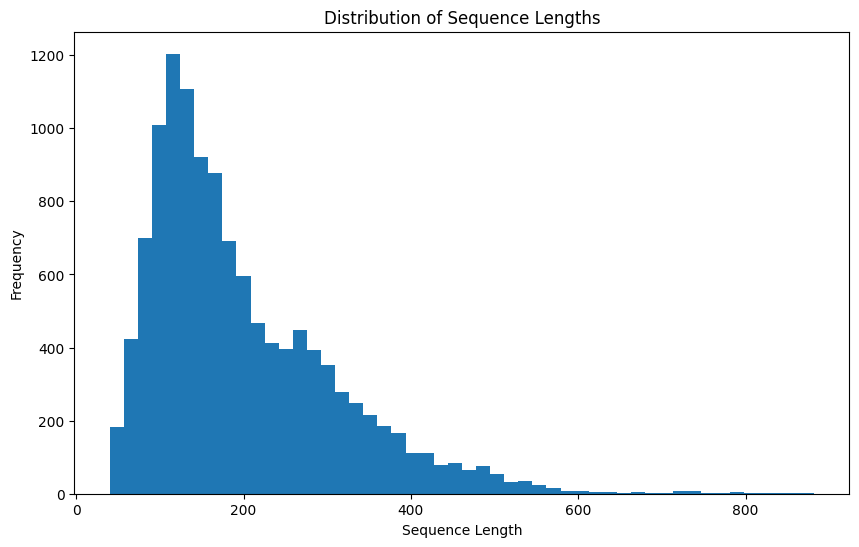

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

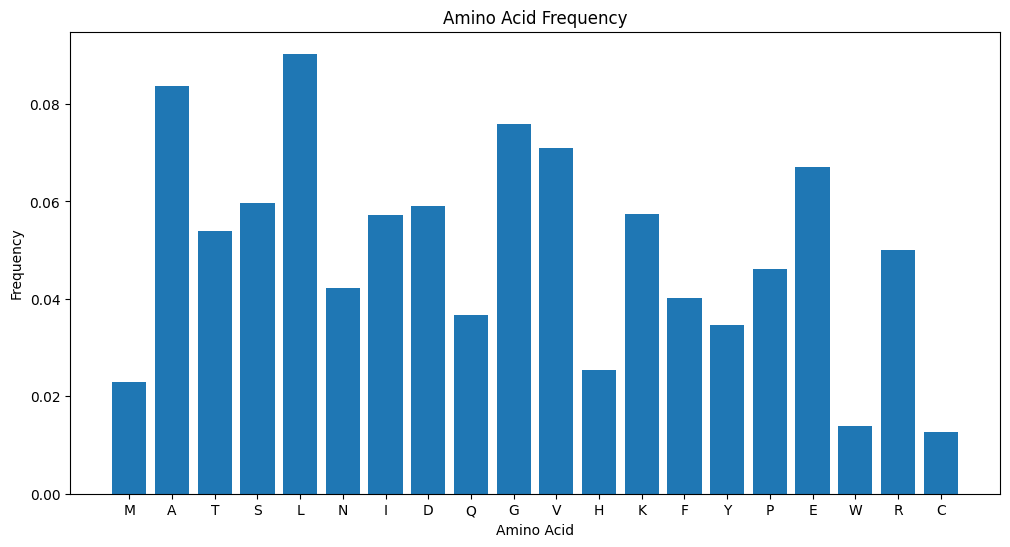

In [12]:
aa_counts = Counter("".join(sequences))
total_aa = sum(aa_counts.values())
aa_freq = {aa: count/total_aa for aa, count in aa_counts.items()}

plt.figure(figsize=(12, 6))
plt.bar(aa_freq.keys(), aa_freq.values())
plt.title("Amino Acid Frequency")
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.show()

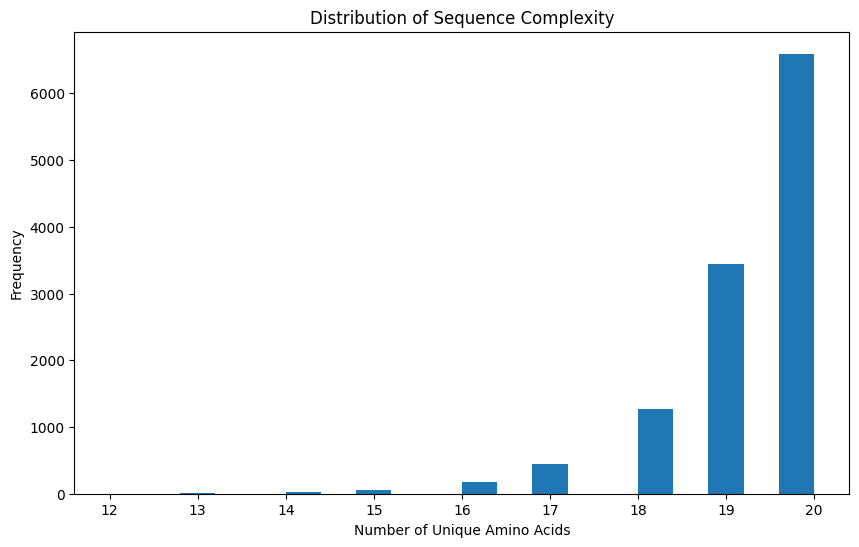

In [13]:
seq_complexity = [len(set(seq)) for seq in sequences]

plt.figure(figsize=(10, 6))
plt.hist(seq_complexity, bins=20)
plt.title("Distribution of Sequence Complexity")
plt.xlabel("Number of Unique Amino Acids")
plt.ylabel("Frequency")
plt.show()

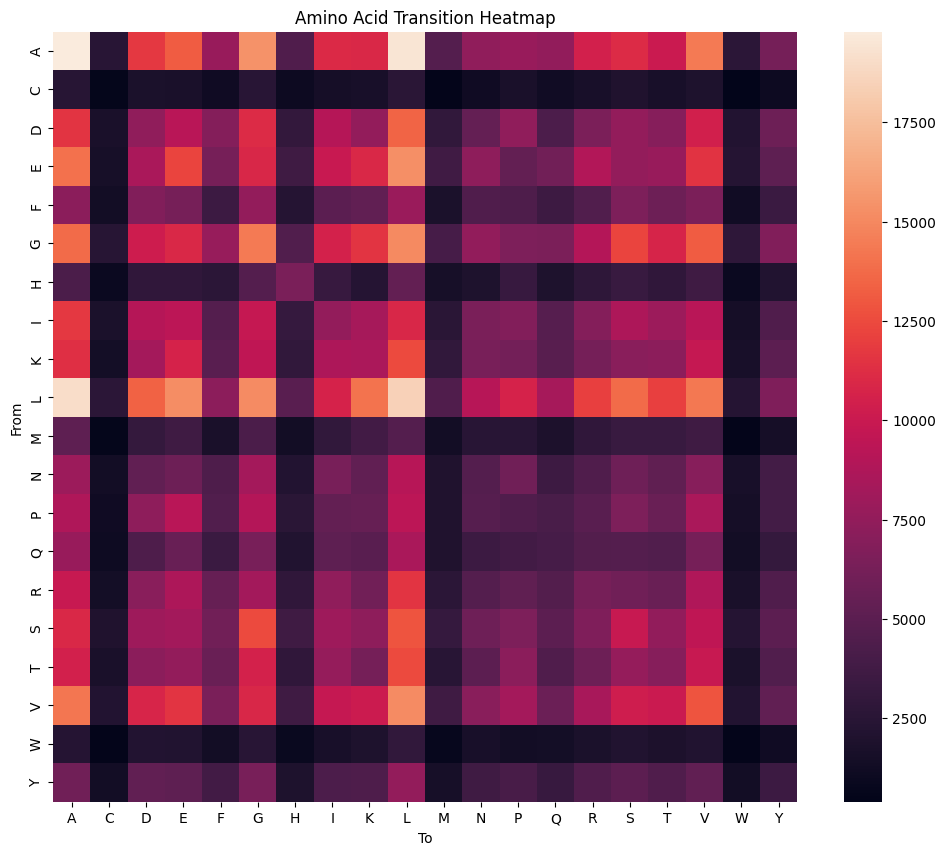

In [14]:
aa_list = sorted(set("".join(sequences)))
transition_matrix = np.zeros((len(aa_list), len(aa_list)))

for seq in sequences:
    for i in range(len(seq)-1):
        row = aa_list.index(seq[i])
        col = aa_list.index(seq[i+1])
        transition_matrix[row, col] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix, xticklabels=aa_list, yticklabels=aa_list)
plt.title("Amino Acid Transition Heatmap")
plt.xlabel("To")
plt.ylabel("From")
plt.show()

In [17]:
sequences[0:2]

['MATSLNTIDIQGDILVGMHKQKQLFYFFAINDPATFKTHLASDIAPVVASVTQLSNVATQPLVALNIAFSNTGLLALGVTDNLGDSLFANGQAKDATSFKESTSSWVPQFAGTGIHGVIILASDTTDLIDQQVASIESTFGSSISKLSSLSASIRPGNEAGHEMFGFLDGIAQPAINGFNTPLPGQNIVDAGVIITGATNDPITRPSWAVGGSFLAFRQLEQLVPEFNKYLLDNAPAGSGSLQARADLLGARMVGRWKSGAPIDLTPTADDPALGADAQRNNNFTYSHAGFDLGSDQSHCPFSAHIRKTRPRADLGGSLTPPNLSAGANSIMRSGIPYGPEVTSAESASNTTTQERGLAFVAYQAQLSQGFHFLQQTWADNANFPPGKTPATVGLDPIIGQNNGQPRVVNGLLPSNSSASLSIPQFVVSHGGEYFFSPPISAIGGRLSA',
 'MVKHIVLFKLRDDVPVEEKLVVMNSFKEAIEALPAKISVIRKIEVGLNMNPGETWNIALYSEFDNLDDVKFYATHPEHVAAGKILAETKESRACVDYEF']

### Data Loading

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from esm.data import Alphabet, ESMStructuralSplitDataset

# Load datasets
train_data = ESMStructuralSplitDataset(split_level='family', cv_partition='0', split='train')
valid_data = ESMStructuralSplitDataset(split_level='family', cv_partition='0', split='valid')

In [93]:
import torch
from torch.utils.data import Dataset, DataLoader
from esm.data import Alphabet, ESMStructuralSplitDataset

class ProteinDataset(Dataset):
    def __init__(self, split='train', max_len=500):
        self.data = ESMStructuralSplitDataset(split_level='family', cv_partition='0', split=split)
        self.alphabet = Alphabet.from_architecture('ESM-1b')
        self.batch_converter = self.alphabet.get_batch_converter(truncation_seq_length=max_len)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return (str(idx), item['seq'])  # Return a tuple of (label, sequence)

import torch

def collate_batch(batch):
    labels, seqs = zip(*batch)
    batch_converter = Alphabet.from_architecture('ESM-1b').get_batch_converter(truncation_seq_length=500)
    _, _, batch_tokens = batch_converter(list(zip(labels, seqs)))
    return batch_tokens  # Ensure we're returning the tokens tensor directly

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)


## Confirming Data Loader accuracy

In [33]:
import torch
from esm.data import Alphabet, ESMStructuralSplitDataset

# 1. Examine the data structure
train_data = ESMStructuralSplitDataset(split_level='family', cv_partition='0', split='train')

print("Dataset length:", len(train_data))
print("\nExample data item:")
print(train_data[0])

# 2. Check the alphabet and tokenization
alphabet = Alphabet.from_architecture('ESM-1b')
print("\nAlphabet size:", len(alphabet))

# 3. Create a small batch and tokenize it
batch_converter = alphabet.get_batch_converter()

# Prepare a small batch
small_batch = [
    ("protein1", train_data[0]['seq']),
    ("protein2", train_data[1]['seq']),
    ("protein3", train_data[2]['seq'])
]

# Convert the batch to tensors
labels, strs, tokens = batch_converter(small_batch)

print("\nTokenized batch shape:", tokens.shape)
print("First sequence tokens:", tokens[0][:10])  # Print first 10 tokens of the first sequence

# 4. Check for any non-standard amino acids
unique_aas = set(''.join([item['seq'] for item in train_data]))
print("\nUnique amino acids in the dataset:", sorted(unique_aas))
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")
non_standard = unique_aas - standard_aas
if non_standard:
    print("Non-standard amino acids found:", non_standard)
else:
    print("No non-standard amino acids found.")

# 5. Check sequence lengths
seq_lengths = [len(item['seq']) for item in train_data]
print("\nSequence length stats:")
print(f"Min: {min(seq_lengths)}, Max: {max(seq_lengths)}, Mean: {sum(seq_lengths)/len(seq_lengths):.2f}")

Dataset length: 12026

Example data item:
{'seq': 'MATSLNTIDIQGDILVGMHKQKQLFYFFAINDPATFKTHLASDIAPVVASVTQLSNVATQPLVALNIAFSNTGLLALGVTDNLGDSLFANGQAKDATSFKESTSSWVPQFAGTGIHGVIILASDTTDLIDQQVASIESTFGSSISKLSSLSASIRPGNEAGHEMFGFLDGIAQPAINGFNTPLPGQNIVDAGVIITGATNDPITRPSWAVGGSFLAFRQLEQLVPEFNKYLLDNAPAGSGSLQARADLLGARMVGRWKSGAPIDLTPTADDPALGADAQRNNNFTYSHAGFDLGSDQSHCPFSAHIRKTRPRADLGGSLTPPNLSAGANSIMRSGIPYGPEVTSAESASNTTTQERGLAFVAYQAQLSQGFHFLQQTWADNANFPPGKTPATVGLDPIIGQNNGQPRVVNGLLPSNSSASLSIPQFVVSHGGEYFFSPPISAIGGRLSA', 'ssp': 'XXX---GGGSBHHHHT----SEEEEEEEEE-SHHHHHHHIIIIIGGGB-BHHHHTSTTS--SEEEEEEE-HHHHHHTT-----S-HHHHH-HHHHGGGGT--GGGS-GGGSSS---EEEEEEESSHHHHHHHHHHHHHHHGGGEEEEEEEEEE---GGGTTB-TTS-B-S----EETTTS---TT--EE-GGGTSTTSTT--S---GGGTT-EEEEEEEEEE-HHHHHHHHHHT----SS-HHHHHHHHHHHHHSB-TTS-BTTTSSSS--HHHHH-TTTTT---S--TTS-TTT--SSS-TT-HHHHHS-GGGGSS-SSS---TTGGG--EE--EEES----HHHHHHT---S--EEEEEEEES-TTTTHHHIIIIIIT-TT-STT-SSS--B--TTT--STTS-EEEES--TT-TT-EEEE--SEEEEEEEEEEE--HHHHHTGGG-', 'dist': array([[      nan,       nan,

# LLM Model Initialization

In [85]:
from esm.model.esm2 import ESM2

def create_small_esm2(alphabet):
    return ESM2(
        num_layers=4,
        embed_dim=256,
        attention_heads=4,
        alphabet=alphabet,
        token_dropout=True
    )

In [86]:
def mask_tokens(inputs, mask_token_id, vocab_size, mask_prob=0.15):
    labels = inputs.clone()
    probability_matrix = torch.full(labels.shape, mask_prob, device=inputs.device)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    
    inputs[masked_indices] = mask_token_id
    
    return inputs, labels

In [94]:
def train(model, train_loader, optimizer, device, mask_token_id, vocab_size):
    model.train()
    total_loss = 0
    start_time = time.time()
    
    for batch_idx, batch_tokens in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Move batch_tokens tensor to the device
        batch_tokens = batch_tokens.to(device)
        
        masked_inputs, labels = mask_tokens(batch_tokens, mask_token_id, vocab_size)
        
        outputs = model(masked_inputs)
        loss = nn.CrossEntropyLoss(ignore_index=1)(outputs['logits'].view(-1, vocab_size), labels.view(-1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 10 == 0:  # Log every 10 batches
            elapsed = time.time() - start_time
            print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Time: {elapsed:.2f}s")
            wandb.log({"batch": batch_idx, "loss": loss.item(), "time_per_10_batches": elapsed})
            start_time = time.time()
    
    return total_loss / len(train_loader)


In [99]:
import wandb
import time 

def main():
    # Initialize wandb
    wandb.init(project="esm2-small-11")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    alphabet = Alphabet.from_architecture("ESM-1b")
    model = create_small_esm2(alphabet)
    model.to(device)
    
    # Log model architecture
    wandb.watch(model)
    
    train_dataset = ProteinDataset(split='train')
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Log hyperparameters
    wandb.config.update({
        "learning_rate": 1e-4,
        "batch_size": 32,
        "num_epochs": 10,
        "model_layers": 4,
        "embed_dim": 256,
        "attention_heads": 4
    })
    
    num_epochs = 10
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        loss = train(model, train_loader, optimizer, device, alphabet.mask_idx, len(alphabet))
        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Time: {epoch_time:.2f}s")
        wandb.log({"epoch": epoch+1, "loss": loss, "epoch_time": epoch_time})
    
    wandb.finish()


In [100]:
main()

Python(36904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


AttributeError: 'list' object has no attribute 'to'

In [98]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  

import torch

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {device}")
x = torch.randn(3, 3)
x = x.to(device)
print(x)


PyTorch version: 2.4.0
Device available: mps
tensor([[-0.3870,  1.0139, -0.3934],
        [-0.7112,  1.0376, -0.1130],
        [-0.4743, -1.6487, -0.3338]], device='mps:0')


In [102]:
import torch
from esm.data import Alphabet, ESMStructuralSplitDataset
import torch.nn as nn

# Device selection for M1 Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

def collate_batch(batch):
    labels, seqs = zip(*batch)
    batch_converter = Alphabet.from_architecture('ESM-1b').get_batch_converter(truncation_seq_length=500)
    _, _, batch_tokens = batch_converter(list(zip(labels, seqs)))
    return batch_tokens.to(device)  # Ensure tensor is moved to the correct device

def mask_tokens(inputs, mask_token_id, vocab_size, mask_prob=0.15):
    labels = inputs.clone()
    probability_matrix = torch.full(labels.shape, mask_prob, device=inputs.device)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    
    inputs[masked_indices] = mask_token_id
    
    return inputs, labels

def train(model, train_loader, optimizer, device, mask_token_id, vocab_size):
    model.train()
    total_loss = 0
    start_time = time.time()
    
    for batch_idx, batch_tokens in enumerate(train_loader):
        optimizer.zero_grad()
        
        masked_inputs, labels = mask_tokens(batch_tokens, mask_token_id, vocab_size)
        
        outputs = model(masked_inputs)
        loss = nn.CrossEntropyLoss(ignore_index=1)(
            outputs['logits'].view(-1, vocab_size), 
            labels.view(-1)
        )
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 10 == 0:  # Log every 10 batches
            elapsed = time.time() - start_time
            print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Time: {elapsed:.2f}s")
            wandb.log({"batch": batch_idx, "loss": loss.item(), "time_per_10_batches": elapsed})
            start_time = time.time()
    
    return total_loss / len(train_loader)

import wandb
import time 

def main():
    # Initialize wandb
    wandb.init(project="esm2-small-13")
    
    alphabet = Alphabet.from_architecture("ESM-1b")
    model = create_small_esm2(alphabet)
    model.to(device)
    
    # Log model architecture
    wandb.watch(model)
    
    train_dataset = ProteinDataset(split='train')
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Log hyperparameters
    wandb.config.update({
        "learning_rate": 1e-4,
        "batch_size": 32,
        "num_epochs": 10,
        "model_layers": 4,
        "embed_dim": 256,
        "attention_heads": 4
    })
    
    num_epochs = 10
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        loss = train(model, train_loader, optimizer, device, alphabet.mask_idx, len(alphabet))
        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Time: {epoch_time:.2f}s")
        wandb.log({"epoch": epoch+1, "loss": loss, "epoch_time": epoch_time})
    
    wandb.finish()

main()


Python(37649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(43931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43978) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44045) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44117) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44164) Malloc

Batch 10/376, Loss: 2.0358, Time: 1814.84s


Python(56291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56510) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(56534) Malloc

Batch 20/376, Loss: 0.9102, Time: 3582.43s


Python(92550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92783) Malloc

Batch 30/376, Loss: 0.6111, Time: 4220.65s


Python(33901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33946) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(33990) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34036) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34104) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34125) Malloc

Batch 40/376, Loss: 0.5422, Time: 2709.24s


Python(60550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60749) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60793) Malloc

Batch 50/376, Loss: 0.4790, Time: 1097.49s


Python(71651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(71875) Malloc

Batch 60/376, Loss: 0.4797, Time: 1578.43s


Python(87696) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(87936) Malloc

Batch 70/376, Loss: 0.4893, Time: 1099.55s


Python(98989) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99159) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99211) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(99257) Malloc

Batch 80/376, Loss: 0.4457, Time: 4284.73s


Python(38559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38791) Malloc

Batch 90/376, Loss: 0.4831, Time: 1254.25s


Python(51284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51507) Malloc

Batch 100/376, Loss: 0.4513, Time: 2304.06s


Python(64711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64947) Malloc

Batch 110/376, Loss: 0.4690, Time: 967.88s


Python(74515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(74755) Malloc

KeyboardInterrupt: 